# Machine Learning Ising model from scratch:
In this notebook, Markov Chain Monte Carlo sampling is used to sample configurations of Ising model for T=1 to T=3. Full-connected Neural Network(FCNN) is applied to learn the classifier of paramagnetism and ferromagnetism phases. The FCNN is done from scratch and later by TensorFlow.


# Classical Ising model
$H=-J\sum_{<i,j>}S_{i}S_{j}$
The "data" of the ML problem corresponds to configuration of Ising model.
That is, $\vec{x}=(s_{1},s_{2},...,s_{N})$ where $s_{i}= 1, -1$.

We label our Ising model data by its phase. For $T<T_{C}$ we label this ferromagnetic phase $y=1$ and $T>T_{C}$ for paramagnetic phase,  $y=0$

We'll generate those datas from some distribution by Monte Carlo method. The distribution behind the data is Boltzmann distribution $P_{\mu}=\frac{1}{Z}e^{-\beta E_{\mu}}$

We use MCMC to sample states by updating the current state $\mu$ to next one $\nu$. In principle, any rule of updating is possible. For example, given state $\vec{x}_{\mu}=(1,-1,-1,1,1)$, we can propose next one $\vec{x}_{\nu}$ by


(1)Single spin flip: $\vec{x}_{\nu}=(-1,-1,-1,1,1)$ 

(2)Non-local spin flip (cluster algorithm): $\vec{x}_{\nu}=(-1,1,1,-1,-1)$   (Just for specific example)

However, we should restrict the rule of updating due to the $P_{\mu}$ from which we hope our sampling won't be too irrelevant, the so-called importance sampling. We should encode the underlying Boltzmann distribution to our sampling rule which we denote by $T(\mu \rightarrow\nu)$. Computationally we can write this T by $T(\mu\rightarrow\nu)=g(\mu\rightarrow\nu)A(\mu\rightarrow\nu)$, where $g(\mu\rightarrow\nu)$ is proposal rate and $A(\mu\rightarrow\nu)$ is acceptance rate. The transition probability $T(\mu \rightarrow\nu)$ satisfies the following two quite general conditions:

(1) Normalized transition probability: $\sum_{\nu}T(\mu\rightarrow\nu)=1$

(2) Detailed balance: $P_{\nu}T(\nu\rightarrow\mu)=P_{\mu}T(\mu\rightarrow\nu)$

Since $P_{\mu}$ is Boltzmann distribution, apply detailed balance then we have $\frac{T(\mu->\nu)}{T(\nu->\mu)}=e^{-\beta(E_{\nu}-E_{\mu})}$

Write by proposal and acceptance rate, we have $\frac{A(\mu\rightarrow\nu)}{A(\nu\rightarrow\mu)}=\frac{g(\nu\rightarrow\mu)}{g(\mu\rightarrow\nu)}e^{-\beta(E_{\nu}-E_{\mu})}$

Any Monte Carlo algorithm with g and A satisfying this equation can do the job. One of them is the famous Metropolis Algorithm: $A(\mu\rightarrow\nu)=\text{min}(1,\frac{g(\nu\rightarrow\mu)}{g(\mu\rightarrow\nu)}e^{-\beta(E_{\nu}-E_{\mu})})$. This way of encoding underlying distribution can optimizes the acceptance rate under the consideration of importance sampling. That is, proposal of the highly probable states should be highly accepted. The higher the acceptance rate for important states the more efficient the sampling is.

# Applications of Monte Carlo in Machine Learning (To be completed...)
MCMC sampling can be used in many ML algorithm in the future, here we list some yet many more items are to be included

(1) Sampling states.
(2) Approximate the gradient in RBM. 
(3)....

# Pseudo code of MCMC sampling


choose an initial state $\mu_{1}$ randomly.

for i = 2 ~ N

{    

use $g(\mu_{i-1}\rightarrow\nu)$ to propose an update

generate a number r uniformly randomly from [0,1)
    

compare this random number r with A($\mu_{1}\rightarrow\nu$) which is from Metropolis algorithm : 
if r< A($\mu_{1}\rightarrow\nu$)  then accept this new state by assigning $\mu_{i}=\nu$
    

else $\mu_{i}=\mu_{i-1}$

}

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import boltzmann as bzm

Now we use MCMC to sample states and calculate the average energy of the whole system at some temperature T.

In [2]:
# Define energy function to calculate energy according to Ising Hamiltonian
def energy(state, N, nbr):
    E = 0.0
    for k in range(N):
        E -=  state[k] * sum(state[nn] for nn in nbr[k])
    return 0.5 * E

# Define the lattice by neighbors of each site. (with periodic b.c.)
L = 10
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}

T = 2.0                                                             # Temperature
state = [random.choice([1, -1]) for k in range(N)]                  # Generate an initial state randomly
nsteps = N * 300                                                    # Number of proposals
Energy = energy(state, N, nbr)                                      # Energy of the whole lattice initially
E = np.zeros(nsteps)                                                # To record energies of sampled states
States = np.zeros((nsteps,N))                                           # To record sampled states
accept = 0                                                          # To Count the number of acceptance
for step in range(nsteps):                                          # Going to propose nstep move to flip spin
    k = random.randint(0, N - 1)                                    # Randomly pick a spin among the N sites   
    delta_E = 2.0 * state[k] * sum(state[nn] for nn in nbr[k])      # Calculate the energy change due to this flip. 
    if random.uniform(0.0, 1.0) < math.exp(-1.0 / T * delta_E):     # The condition for acceptance (Think about the condition)
        accept += 1
        state[k] *= -1                                              # Satisfy the condition, flip this spin
        Energy += delta_E                                           # Fulfill the energy change
    States[step] = np.array(state)                                  # Record this new state
    E[step] = Energy                                                # Record the energy of this step
    
print('mean energy per spin:', sum(E) / float(len(E) * N),'Number of acceptance', accept, 'acceptance rate:', accept/nsteps)          

mean energy per spin: -1.7392933333333334 Number of acceptance 2537 acceptance rate: 0.08456666666666666


Before we sample more states for different temperatures T, we note that in the present T=2 case, the states we sample are indeed the relevant ones as shown in the histogram graph below.

(array([6.763e+03, 6.968e+03, 5.195e+03, 6.570e+03, 2.454e+03, 7.750e+02,
        6.940e+02, 1.150e+02, 5.400e+01, 9.400e+01, 1.580e+02, 7.300e+01,
        2.300e+01, 1.400e+01, 7.000e+00, 7.000e+00, 3.000e+00, 8.000e+00,
        2.200e+01, 3.000e+00]),
 array([-2.   , -1.894, -1.788, -1.682, -1.576, -1.47 , -1.364, -1.258,
        -1.152, -1.046, -0.94 , -0.834, -0.728, -0.622, -0.516, -0.41 ,
        -0.304, -0.198, -0.092,  0.014,  0.12 ]),
 <a list of 20 Patch objects>)

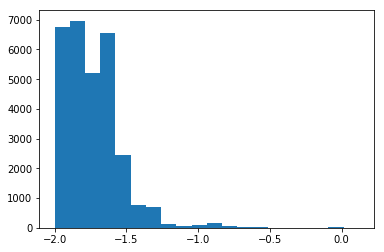

In [3]:
plt.hist(E/N,bins=20)

# Start sampling
First, define the system size.

In [4]:
# Define the lattice by neighbors of each site. (with periodic b.c.)
L = 10
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}

To sample for different T, we divide the temperature interval from T=1 to T=3 into pieces.

In [5]:
T = np.zeros(200)                                              # Set up temperature series
T[0] = 1
for delta in range(199): 
    T[delta+1] = T[delta]+0.01
T    

array([1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99, 2.  , 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09,
       2.1 , 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2 ,
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.

In [6]:
nsteps = N * 100                                                        # Number of proposals
S = np.zeros((len(T),nsteps,N))                                         # To record sampled states
E = np.zeros((len(T), nsteps))                                          # To record energies of sampled states
state = [random.choice([1, -1]) for k in range(N)]                      # Generate an initial state randomly
Energy = energy(state, N, nbr)                                          # Energy of the whole lattice initially

for t in range(len(T)):                                                 # iterate all temperatures
    for step in range(nsteps):                                          # Going to propose nstep move to flip spin
        k = random.randint(0, N - 1)                                    # Randomly pick a spin among the N sites   
        delta_E = 2.0 * state[k] * sum(state[nn] for nn in nbr[k])      # Calculate the energy change due to this flip. 
        if random.uniform(0.0, 1.0) < math.exp(-1.0 / T[t] * delta_E):     # The condition for acceptance (Think about the condition)
            state[k] *= -1                                              # Satisfy the condition, flip this spin
            Energy += delta_E                                           # Fulfill the energy change
        S[t, step] = np.array(state)                                    # Record this new state
        E[t, step] = Energy                                             # Record the energy of this step
    

In [7]:
S.shape # We have dataset S now , where S[T][i][j] is spin value of jth site in ith data at temperature T

(200, 10000, 100)

(array([ 842.,    0., 1128.,  297., 1619.,  690.,  939., 1007., 1182.,
           0.,  883.,  376.,  317.,  211.,  169.,  224.,   67.,   11.,
          20.,   18.]),
 array([-2.   , -1.964, -1.928, -1.892, -1.856, -1.82 , -1.784, -1.748,
        -1.712, -1.676, -1.64 , -1.604, -1.568, -1.532, -1.496, -1.46 ,
        -1.424, -1.388, -1.352, -1.316, -1.28 ]),
 <a list of 20 Patch objects>)

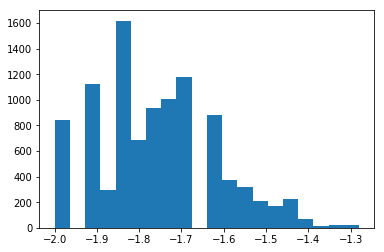

In [8]:
plt.hist(E[100]/N,bins=20)     # Try to plot energy distribution of samples given some temperature

# Now We have dataset sampled from Boltzmann distribution. State $S[t][i][j]$ and energy $E[t][i]$ where t refer to t-th temperature, i for i-th data, j for j-th lattice site.

# Data preprocessing

Based on theoretical study, the critical temperature of Ising model is $T_{c} = \frac{2}{ln(1+\sqrt{2})}\approx 2.2692􏰔$. We will try to classify states by paramagnetism (T>Tc) and ferromagnetism.(T<Tc)

In [9]:
Tc = 2.0/math.log(1.0+2**(1/2.0))
Tc

2.269185314213022

Split dataset into two phase categories. To do so, we search for the t point that represent Tc and seperate dataset by it.  

In [10]:
x = np.zeros((len(T), nsteps, N))
y = np.zeros((len(T), nsteps, 2))
for t in range(len(T)):
    if T[t] < Tc: 
            x[t] = x[t] + S[t]
            y[t] = y[t] + [1.0, 0.0]
    else: 
            x[t] = x[t] + S[t]
            y[t] = y[t] + [0.0, 1.0]

Now the input data $x[t][i][j]$ and the label $y[t][i]$ are consistent in t and i index. What we wanna feed into Machine learning is spin configuration $(x_{[t][i]})[j]$ and its label $y_{[t][i]}$. We can unfold the t,i index by numpy.reshape function.

In [11]:
x_data = np.reshape(x, (len(T)*nsteps, N))
y_data = np.reshape(y, (len(T)*nsteps, 2))

In [12]:
x_data.shape, y_data.shape

((2000000, 100), (2000000, 2))

Now we've represented our "raw data" S by (x_data, y_data). We now separate it into training set (x_data_train, y_data_train) and test set (x_data_test, y_data_test).

Before doing so, we need to shuffle our data. Be careful to keep the one-to-one correspondance of x and y unchanged when shuffling. This can be done by combining x, y to form a list of tuple (x, y) and then shuffle this list. The build-in function zip() can do this. (Note: 9,000,000 datas need 2 min to run this code.)

In [13]:
c = list(zip(x_data, y_data))
random.shuffle(c)

In [16]:
len(c)

6000000

Now we have c, the full data (x,y) randomly shuffled. 

Now we pick a portion of dataset (x,y) since we don't need so huge dataset for training Ising model. 

In [14]:
data_portion = int(len(c)/500)
x_picked = np.zeros((data_portion, N))
y_picked = np.zeros((data_portion, 2))
for i in range(data_portion):
    x_picked[i] = c[i][0]
    y_picked[i] = c[i][1]

# Load the data to a csv file

In [177]:
x_y_comined = np.array(list(zip(x_picked, y_picked)))

In [181]:
np.savetxt("ising.csv",x_y_comined , delimiter=',', header="state,phase", comments="")

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e,%.18e')

# Split data into train and test set.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_picked, y_picked, test_size=0.20, random_state=42)

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3200, 100), (800, 100), (3200, 2), (800, 2))

For later use, we transpose the data x and y. (Since in training, we'll do Wx+b where component of data are summed. Thus component index should be moved ahead.)

In [18]:
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

In [19]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((100, 3200), (100, 800), (2, 3200), (2, 800))

# DNN From scratch

The archetecture of NN is $a^{(\ell)} = g(z^{(\ell)}) = g(w^{(\ell)}a^{(\ell-1)}+b^{(\ell)})$, where $g= \frac{1}{1+e^{-z}}$ is logistic function. Note that $\ell= 1,2,...,L$. $w^{(\ell)}$ and $b^{(\ell)}$ are weight and bias of $\ell$-th layer. $a^{(0)}$ is just input data x and $a^{(L)}$ is just predicted label.

To build NN by hand , we have to build some helper functions 

First, define the parameter initilizer which can generate initialization of parameters of any NN depth.
We input dimension of every layer(a list), it output the initialized parameters (a dictionary).

In [20]:
def initialize_nn_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)                     # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    
    return parameters

def activation_list(ActList):           # If input is (3,1), output will be ['relu', 'relu', 'relu', 'sigmoid']
    act_list = []
    a = ActList[0]
    b = ActList[1]
    for l in range(1, a+b+1):
        if l <= a:
            act_list += ['relu']
        else:
            act_list += ['sigmoid']
    return act_list                       # If NN has L layers, this act_list will be indexed from [0] to [L-1]


def sigmoid(Z):
    A = 1.0/(1+math.e**(-Z))
    return A

def sigmoid_backward(dA, A):
    dZ = dA*A*(1-A)
    return dZ

Second, to build the whole feed-forward function. We consider the process $a^{(\ell)} = g(w^{(\ell)}a^{(\ell-1)}+b^{(\ell)})$ for $\ell$-th layer and stack such layer from $\ell=0$ to $\ell=L$ together to form the whole feed-forward function.

In [21]:
# l-th layer forward propagation 
# Input W is (n_l, n_l-1), A_prev is (n_l-1, m), b is (n_l, 1)  ;   PS. m is number of datas
# Output Z is (n_l, m)
 

# Input X is (N, m) where N is # of components of data, m is # of datas
def forward_one(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    if activation == "sigmoid":            # Note that we haven't applied other activation function
        A = sigmoid(Z)
        cache = (A, Z, A_prev, W, b)       # Use a tuple to store A,W,b at this layer for later use in GD.
    return A, cache

# Input X is (N, m) where N is # of components of data, m is # of datas
def forward_L(X, parameters, activation):
    caches = []
    A = X
    L = len(parameters) // 2           # number of layers in the neural network
    
    # Implement [forward_one]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_one(A_prev, parameters["W"+str(l)] , parameters["b"+str(l)] , activation )
        caches.append(list(cache))
    AL, cache = forward_one(A, parameters["W"+str(L)] , parameters["b"+str(L)] , activation)
    caches.append(list(cache))   
    # Worth to remind : caches[l] = [A, Z, A_prev, W, b]  for l=0~L
    return AL, caches

We have built full forward propagation. Then we define a cost function for this output.

In [22]:
def compute_cost(AL, Y, cost_function):
    if cost_function == "cross_entropy":            # Note that we haven't applied other kind of cost function
        cost = -1/(Y.shape[1])*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
        
    cost = np.squeeze(cost)
    return cost

After complete the NN architecture, we now build the training process which is called backward propagation in NN. 

First, the same as forward prop., we deal with l-th layer backward prop. and then stack such layer from $\ell=0$ to $\ell=L$ together to form the whole feed-forward function.

In [23]:
# In back prop. we will make use of cache in forward prop.

def backward_one(dA, cache, activation):
    A, Z, A_prev, W, b = cache
    m = A_prev.shape[1]
    if activation == "sigmoid":           # Note that we haven't included other activation function
        dZ = sigmoid_backward(dA, A)
        dW = 1/m*np.dot(dZ,A_prev.T)
        db = 1/m*np.sum(dZ,axis=1,keepdims=True)
        dA_prev = np.dot(W.T,dZ)
        
    return dA_prev, dW, db     

def backward_L(AL, Y, caches, activation):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # To start back prop., we need to compute dAL by hand
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))         # This is the case for the cross entrypy
    
    # Lth layer backward_one gradients. 
    #Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_one(dAL, current_cache , activation)
    # Implement [backward_one]*(L-1)
    for l in reversed(range(L-1)):
        #l-th layer
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_one(grads["dA" + str(l+1)], current_cache , activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
        return grads

Second, we update the weight and bias by this grads. $W^{[\ell]}=W^{[\ell]} - \lambda dW^{[\ell]}$ and $b^{[\ell]}=b^{[\ell]} - \lambda db^{[\ell]}$

In [24]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    return parameters    

# Finally, build the training model composed of these helper funtions, which looks like this following sequence

(1) initialize_nn_parameters(layer_dims) $\Longrightarrow$ parameters={W,b}

(2) forward_L(x_train, parameters, activation) $\Longrightarrow$ AL, caches={A, Z, A_prev, W, b}

(3) compute_cost(AL, y_train, cost_function) $\Longrightarrow$ cost   

(4) backward_L(AL, y-train, caches, activation) $\Longrightarrow$ grads={dA, dW, db}

(5) update_parameters(parameters, grads, learning_rate) $\Longrightarrow$ parameters={W,b}

# Start training

Try two layer NN, we set up some "hyper-parameters" of training

In [40]:
costs = []                              # To record the cost over epoches for later graph plot
m = x_train.shape[1]                    # Number of examples
epoches = 3000
learning_rate = 0.01
layers_dims = (N, 100, 2)               # NN structure

Start training

In [41]:
parameters = initialize_nn_parameters(layers_dims)

for epo in range(0, epoches):
    
    AL, caches = forward_L(x_train, parameters, activation = "sigmoid")  
    cost = compute_cost(AL, y_train, cost_function = "cross_entropy")
    grads = backward_L(AL, y_train, caches, activation = "sigmoid")
    parameters = update_parameters(parameters, grads, learning_rate)
    
    if epo % 100 == 0:
        print ("Cost after iteration %i: %f" %(epo, cost))
        costs.append(cost)

Cost after iteration 0: 1.385068
Cost after iteration 100: 1.301457
Cost after iteration 200: 1.265188
Cost after iteration 300: 1.188611
Cost after iteration 400: 1.061132
Cost after iteration 500: 0.928360
Cost after iteration 600: 0.836884
Cost after iteration 700: 0.783480
Cost after iteration 800: 0.751952
Cost after iteration 900: 0.732022
Cost after iteration 1000: 0.718457
Cost after iteration 1100: 0.708595
Cost after iteration 1200: 0.701019
Cost after iteration 1300: 0.694930
Cost after iteration 1400: 0.689856
Cost after iteration 1500: 0.685505
Cost after iteration 1600: 0.681691
Cost after iteration 1700: 0.678287
Cost after iteration 1800: 0.675209
Cost after iteration 1900: 0.672395
Cost after iteration 2000: 0.669802
Cost after iteration 2100: 0.667397
Cost after iteration 2200: 0.665153
Cost after iteration 2300: 0.663050
Cost after iteration 2400: 0.661073
Cost after iteration 2500: 0.659208
Cost after iteration 2600: 0.657444
Cost after iteration 2700: 0.655772
Cost

The learned parameters is

In [145]:
parameters

{'W1': array([[ 0.02044446,  0.01796545,  0.01516966, ...,  0.02378165,
          0.02454109,  0.01318137],
        [-0.02189228, -0.02683816, -0.00974925, ...,  0.00039355,
         -0.01443828, -0.01425024],
        [ 0.03857717, -0.00103028,  0.02394997, ...,  0.02318799,
          0.00796808,  0.01360305],
        ...,
        [ 0.01276818,  0.02111742,  0.01019426, ...,  0.02548053,
          0.01497349,  0.01950911],
        [-0.00880322,  0.00663747, -0.0151539 , ..., -0.01769319,
         -0.02226783,  0.00547144],
        [-0.02230102, -0.01729107, -0.01239316, ..., -0.01885681,
         -0.0179742 , -0.01369526]]), 'b1': array([[ 0.02425434],
        [-0.01087423],
        [ 0.03731874],
        [ 0.02289231],
        [ 0.02482015],
        [ 0.03143008],
        [ 0.00039957],
        [-0.00630764],
        [ 0.00562742],
        [ 0.00048941],
        [-0.0408732 ],
        [-0.00225806],
        [-0.01359794],
        [ 0.00927689],
        [ 0.00930707],
        [-0.01974

And we can plot the learning progress through plotting cost over epoches

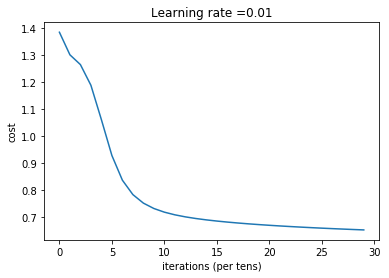

In [42]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

Test the predictibiliy of the trained model.

In [43]:
AL, caches = forward_L(x_test, parameters, activation = "sigmoid")   # Input test set to get the prediction output AL

In [44]:
error = (np.round(AL)-y_test).T        # Get the error matrix by subtracting the rounded AL by y_test

In [45]:
er_count = 0
for i in range(len(error)):
    if error[i][1] != 0.0:
        er_count += 1
print("Number of prediction error is:", er_count)
print("Accuracy of model is:", 1.0 - float(er_count)/float(len(error)))

Number of prediction error is: 94
Accuracy of model is: 0.8825000000000001


# By TensorFlow

In TensorFlow we need to create variables for the parameters and placeholders for the dataset.

Create placeholders

In [32]:
X = tf.placeholder(tf.float32,shape=(None, N),name='X')             # None takes care of number of datas
Y = tf.placeholder(tf.float32,shape=(None, 2),name='Y')

Create variables

In [33]:
W1 = tf.get_variable("W1", [N,100] )
W2 = tf.get_variable("W2", [100,2] )
b1 = tf.get_variable("b1", [1,100] )
b2 = tf.get_variable("b2", [1,2] )

Instructions for updating:
Colocations handled automatically by placer.


Forward propagation

In [34]:
Z1 = tf.add(tf.matmul(X, W1),b1)
A1 = tf.nn.relu(Z1)
Z2 = tf.add(tf.matmul(A1, W2),b2)

Cost function

In [35]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z2, labels = Y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Training lgorithm

In [36]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005).minimize(cost)

Start training

In [37]:
init = tf.global_variables_initializer()

In [1]:
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

NameError: name 'x_train' is not defined

In [ ]:
costs = [] 
num_epochs = 2000
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: x_train, Y: y_train})
          
        if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, temp_cost))
        if print_cost == True and epoch % 20 == 0:
                costs.append(temp_cost)    